In [1]:
# import the necessary data
import datetime
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import io
from alpha_vantage.timeseries import TimeSeries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

reference: 
* https://facebook.github.io/prophet/docs/trend_changepoints.html
* http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html#visualization-autocorrelation
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
* https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
* https://www.alphavantage.co/documentation/

In [3]:
class shares():
    
    '''
    this is the main class 
    1. getting the share price data
    2. make df willl call handle_dates for get the dates ranges
    '''
    # Initialization requires a ticker symbol
    def __init__(self, ticker):
        
        # Enforce capitalization
        ticker = ticker.upper()

        # Symbol is used for labeling plots
        self.symbol = ticker

        #Enter Alpha Vantage API Key
        API_KEY='EM9ML5Z8462GSH50'

        #Based URL with function = 'TIME_SERIES_DAILY'
        ALPHA_URL = 'https://www.alphavantage.co/query?outputsize=full&'
        QUERY_URL = ALPHA_URL+"function=TIME_SERIES_DAILY_ADJUSTED&apikey={KEY}&symbol={SYMBOL}"


        # Getting share price from Alph Vantage
        import json
        import urllib.request


        # open the URL with the stock data of interest
        with urllib.request.urlopen(QUERY_URL.format(KEY=API_KEY, SYMBOL=self.symbol)) as req:
            data = req.read().decode("UTF-8")

        # getting json data back
        json_data = json.loads(data)

        # to confirm there are data returned
        if len(json_data) < 2:
            print ('Unable to get the stock data for ', ticker)
            return None

        # getting keys
        key_dat = list(json_data.keys())[1]

        # getting date/time series
        ts = json_data[key_dat]

        #print ("time series", ts)

        # create datafrome from ts
        stock = pd.DataFrame(ts).T

        # now split columns to get values
        stock = stock.rename(columns={
            "1. open": "Adj. Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. adjusted close": "Adj. Close",
            "6. volume": "Volume",
            "7. dividend amount": "Dividend",
            "8. split coefficient": "Coef"
        })

        share_columns = ["Adj. Open", "High", "Low", "Close", "Adj. Close", "Volume", "Dividend", "Coef"]
        # update the columns to make it easier use
        for col in share_columns:
            if col in stock.columns:
                stock[col] = stock[col].astype(float)

        # clean up some data
        stock.index = pd.to_datetime(stock.index)
        stock["Date"] = stock.index
        stock["Volume"] = stock["Volume"].astype(int)
        
        # Columns required for prophet
        stock['ds'] = stock['Date']
        stock['y'] = stock['Adj. Close']
                
        # Data assigned as class attribute
        self.stock = stock.copy()

        # Minimum and maximum date in range
        self.min_date = min(stock['Date'])
        self.max_date = max(stock['Date'])
        # Start and end date
        self.start_date = self.min_date
        self.end_date = self.max_date
        
    
        # Filling missing dates
        date_index = pd.date_range(start=self.min_date, end=self.max_date)
        stock = stock.reindex(date_index, method='ffill')
                        
                              
        # Find max and min prices and dates on which they occurred
        self.min_price = np.min(self.stock['y'])  # mininum price / date
        self.min_price_date = self.stock[self.stock['y'] == self.min_price]['Date']
        self.min_price_date = self.min_price_date[self.min_price_date.index[0]]

        self.max_price = np.max(self.stock['y'])  # maximum price / date
        self.max_price_date = self.stock[self.stock['y'] == self.max_price]['Date']
        self.max_price_date = self.max_price_date[self.max_price_date.index[0]]

        # data frame are stored in the following sequence : len = 10 ( index starts at 0 )
        #[Adj. Open, High, Low, Close, Adj. Close, Volume, Dividend, Coef, Date, ds, y]

        # The starting price (starting with the opening price)
        self.starting_price = float(self.stock.iloc[0, 0]) #'Adj. Open'

        # The most recent price
        self.most_recent_price = float(self.stock.iloc[len(self.stock) - 1, len(self.stock.columns) - 1])  #'y'

        # This can be changed by user - default for prophet is 0.05
        # Adjusting trend flexibility - increase will make it more flexible
        self.changepoint_prior_scale = 0.2

        print('{} Shares Initialized. Data covers {} to {}.'.format(self.symbol,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
        
        
    
    
    """
    Make sure start and end dates are in the range and can be
    converted to pandas datetimes. Returns dates in the correct format
    """
    def handle_dates(self, start_date=None, end_date=None):
        
        # Set default dates
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
        
        try:
            # Convert to pandas datetime for indexing dataframe
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)

        except Exception as e:
            print('Enter valid pandas date format [yyyy-mm-dd].')
            print(e)
            return

        valid_start = False
        valid_end = False

        # User will continue to enter dates until valid dates are met
        while (not valid_start) & (not valid_end):
            valid_end = True
            valid_start = True

            if end_date.date() < start_date.date():
                print('End Date must be later than start date.')
                start_date = pd.to_datetime(input('Enter a new start date in format [yyyy-mm-dd]: '))
                end_date= pd.to_datetime(input('Enter a new end date in format [yyyy-mm-dd]: '))
                valid_end = False
                valid_start = False

            else:
                if end_date.date() > self.max_date.date():
                    print('End Date exceeds data range' )
                    end_date= pd.to_datetime(input('Enter a new end date before ' + str(self.max_date) + ' in format [yyyy-mm-dd]: '))
                    valid_end = False

                if start_date.date() < self.min_date.date():
                    print('Start Date is before date range')
                    start_date = pd.to_datetime(input('Enter a new start date after  ' + str(self.max_date) + ' in format [yyyy-mm-dd]: '))
                    valid_start = False
        
        # now got the data dates in the range, return dates
        return (start_date, end_date)

    
    """
    Return the dataframe trimmed to the specified range.
    """
    def make_df(self, start_date=None, end_date=None, df=None):

        # Default is to use the object stock data
        if not df:
            df = self.stock.copy()

        # call the handle_date to get proper dates
        start_date, end_date = self.handle_dates(start_date, end_date)

        # keep track of whether the start and end dates are in the data

        # handle start dates
        # ------------------------------
        start_in = True

        if (start_date not in list(df['Date'])):
            start_in = False

        if start_in:  # in data
            trim_df = df[(df['Date'] >= start_date.date())]
        else: # not in data
            trim_df = df[(df['Date'] > start_date.date())]


        # handle end dates
        # ------------------------------
        end_in = True

        if (end_date not in list(df['Date'])):
            end_in = False

        if end_in:  # in data
            trim_df = trim_df[(trim_df['Date'] <= end_date.date())]
        else: # not in data
            trim_df = trim_df[(trim_df['Date'] < end_date.date())]
        
        
        # should make it part of the object???? or not.. if date range changes???

        self.start_date = trim_df.Date[-1]
        self.end_date = trim_df.Date[0]
        self.trim_df = trim_df

        return trim_df
    
    
    # return the min (start) date from original data set from Alpha Vantage
    def get_min_date(self):
        # this value should not be changed
        return self.min_date

    # return the max (end) date from original data set from Alpha Vantage
    def get_max_date(self):
        # this value should not be changed
        return self.max_date
    
    
    # get original stock data set from Alpha Vantage
    def get_full_df_set(self):
        return self.stock
        
    # return the max (end) date users specified
    def get_start_date(self):
        # this will change
        return self.start_date
    
    # return the max (end) date users specified
    def get_end_date(self):
        # this will change
        return self.end_date
    
    # return df based on given date/time 
    def get_trim_df_set(self):
        # this will change
        return self.trim_df
    


    # Basic Historical Plots and Basic Statistics
    def plot_stock(self, start_date=None, end_date=None, stats=['Adj. Close'], plot_type='basic'):

        self.reset_plot()
        
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date

        stock_plot = self.make_df(start_date, end_date)

        colors = ['r', 'b', 'g', 'y', 'c', 'm']

        for i, stat in enumerate(stats):

            stat_min = min(stock_plot[stat])
            stat_max = max(stock_plot[stat])

            stat_avg = np.mean(stock_plot[stat])

            date_stat_min = stock_plot[stock_plot[stat] == stat_min]['Date']
            date_stat_min = date_stat_min[date_stat_min.index[0]].date()
            date_stat_max = stock_plot[stock_plot[stat] == stat_max]['Date']
            date_stat_max = date_stat_max[date_stat_max.index[0]].date()

            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.stock.ix[len(self.stock) - 1, stat], self.max_date.date()))

            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                if stat == 'Daily Change':
                    plt.plot(stock_plot['Date'], 100 * stock_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(stock_plot['Date'], 100 * (stock_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xlabel('Date'); plt.ylabel('Change Relative to Average (%)'); plt.title('%s Stock History' % self.symbol) 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4)

            # Stat y-axis
            elif plot_type == 'basic':
                plt.plot(stock_plot['Date'], stock_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xlabel('Date'); plt.ylabel(' $ '); plt.title('%s Stock History' % self.symbol)
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4)


        plt.style.use('fivethirtyeight')
        plt.show()
        
    # Reset the plotting parameters to clear style formatting
    def reset_plot(self):

        # Restore default parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (16, 4)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'
        
    # rolling average - to see trend/cyclic/seasonal components of the shares price
    def test_stationarity(self, shift_no=0, stats='Adj. Close', wd=22):
        from statsmodels.tsa.stattools import adfuller
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days

        try:
            # get the current dataframe
            df = self.trim_df
        except Exception as e:
            # if don't have create one
            df = self.make_df(self.min_date, self.max_date)

        # differencing
        timeseries = df[stats]
        # differencing
        if shift_no > 0:
            print("shifting : " , shift_no)
            timeseries = df[stats] - df[stats].shift(shift_no)
            timeseries.dropna(inplace=True)
        
        #Determing rolling statistics
        rolmean = timeseries.rolling(wd).mean().dropna()
        rolmedian = timeseries.rolling(wd).median().dropna()
        rolexpand = timeseries.expanding(wd).mean().dropna()
        rolwgh= timeseries.ewm(span=wd).mean().dropna()
        rolstd = timeseries.rolling(wd).std().dropna()
        
        self.reset_plot()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(16, 5))
        orig = plt.plot(timeseries, label='Original')
        mean = plt.plot(rolmean, label='Rolling Mean')
        median = plt.plot(rolmedian, label='Rolling Median')
        expanding = plt.plot(rolexpand, label='Rolling Expanding Mean')
        expandweight = plt.plot(rolwgh, label='Rolling Exponentially weighted mean')
        std = plt.plot(rolstd, label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title( str(wd) + ' days Rolling Statistic')
        plt.show()

        # Perform Dickey-Fuller test:
        # If p value > 0.05 indicates time is non stationary 
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in list(dftest[4].items()):
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
        
        # return if it is stationary or not
        if dfoutput[1] > 0.05:
            # if p value is > 0.05 : non stationary - do something
            return False # 'non-stationary'
        else:
            # if p value is < 0.05 : stationary - do nothing
            return True #'stationary'
        
    '''
    using seasonal_decompose to see trend, seasonality and residuals
    '''
    def decompose_timeseries(self, stats='Adj. Close', freq=22, model='additive'):
        from statsmodels.tsa.seasonal import seasonal_decompose
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days
        self.reset_plot()
        try:
            # get the current dataframe
            df = self.trim_df
        except Exception as e:
            # if don't have create one
            df = self.make_df(self.min_date, self.max_date)
        
        timeseries = df[stats]
        
        # there are 2 types of model
        # model='additive': the seasonal variations are roughly constant through series
        # y(t) = Level + Trend + Seasonality + Noise
        # model='multiplicative': the seasonal variations are changing porportionaly
        # y(t) = Level * Trend * Seasonality * Noise

        # draw decomposition of time series data
        fig = plt.figure(figsize=(16, 5))
        ts_decomp = seasonal_decompose(timeseries, freq=freq, model=model)
        s_plot = ts_decomp.plot()
        plt.show()
        
        # draw the trend
        self.reset_plot()
        fig = plt.figure(figsize=(16, 3))
        plt.scatter(x=timeseries, y=ts_decomp.trend, label = 'Trend')
        plt.title('Trend')
        plt.show()
        
        # draw the seasonality
        self.reset_plot()
        plt.scatter(x=timeseries, y=ts_decomp.seasonal, label = 'Seasonal')
        plt.title('Seasonal')
        plt.show()
        
        # draw the residue or noise
        self.reset_plot()
        plt.scatter(x=timeseries, y=ts_decomp.resid, label = 'Residual')
        plt.title('Residual')
        plt.show()
        

    '''
    I'll be using a few models for prediction one of them is SARIMA model
    SARIMA Model is S-Sesonality, AR -uto regression, 
    I- integration, MA - moving average
    The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.
    '''
    def sarima_model(self, shift_no=0, stats='Adj. Close', freq='MS'):
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days
        self.reset_plot()
#         try:
#             # get the current dataframe
#             df = self.trim_df
#         except Exception as e:
#             # if don't have create one
#             # df = self.make_df(self.min_date, self.max_date)
            
            
        df = self.make_df(self.start_date, self.max_date)
            
        timeseries = df[stats]
        # differencing
        if shift_no > 0:
            print("shifting : " , shift_no)
            timeseries = df[stats] - df[stats].shift(shift_no)
            timeseries.dropna(inplace=True)
    
        
        # setting up seasonal parameters p d and q - based on 12 months (1 year)
        import itertools
        import statsmodels.api as sm
        from matplotlib import pyplot
        from pandas.tools.plotting import autocorrelation_plot
        from statsmodels.tsa.stattools import acf, pacf
        from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
        
        
        # resampling them into monthly information
        y = timeseries.resample(freq).mean()
        
        autocorrelation_plot(y)
        pyplot.show()
        
        #def autocorr_plots(y, lags=None):
        lags=12   # resampling to 12 months a year
        self.reset_plot()
        figure, ax = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
        plot_acf(y, lags = range(1,lags), ax=ax[0])
        plot_pacf(y, lags = range(1,lags), ax=ax[1])
        plt.show()

        # set p, d, q
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


        # find best AIC
        aic_list = []
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(y,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit()
                    aic_list.append({'order': param, 
                                     'seasonal': param_seasonal, 
                                     'aic': results.aic})
                    
                    #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                except:
                    #print('except')
                    continue
                    
        # find the best aic or the smallest aic
        aic_df = pd.DataFrame(aic_list) #, columns=['order', 'seasonal', 'aic'])
        
        aic_df.head()
        min_aic = np.min(aic_df.aic)
        aic_df = aic_df[aic_df.aic == min_aic]
        
        print('ARIMA{}x{}12 - AIC:{}'.format(aic_df.order.values[0], 
                                             aic_df.seasonal.values[0], 
                                             min_aic))
        
        model = sm.tsa.statespace.SARIMAX(y, order=aic_df.order.values[0], #(0, 0, 1),
                                  seasonal_order=aic_df.seasonal.values[0], #(0, 0, 1, 12),
                                  enforce_stationarity=True,
                                  enforce_invertibility=False)
        
        
        # fit the model
        results = model.fit()
        print(results.summary().tables[1])
        
        # draw the results of the model after fitting
        self.reset_plot()
        results.plot_diagnostics(figsize=(16, 8))
        plt.show()
        
        # get number of year for splitting
        max_year = self.max_date.year    # Here is use the dates that I have until the end
        min_year = self.start_date.year   # Here is use the dates that user specified
        years_no = min_year + int((max_year - min_year) * 0.8)
        
        print('starting: {}, ending: {}, no of year for training: {}'.format(min_year, max_year, years_no))
        
        # train data - roughly 16 years
        train = timeseries.loc[:str(years_no)]
        train_values = train.resample(freq).mean()
        train_dates = train.index
        
        # test data - roughly 3 years
        test = timeseries.loc[str(years_no+1):]
        test_values = test.resample(freq).mean()
        test_dates = test.index

        # Validating forecasts - To understand the accuracy of forecasts
        # Compare predicted returns to real returns of the time series
        years_str = str(years_no+1)+'-1-1'
        print (years_str)
        pred = results.get_prediction(start=pd.to_datetime(years_str), dynamic=False)
        pred_ci = pred.conf_int()
        # prediction confident interval
        print('prediction confident interval\n')
        print(pred_ci.head(2))
        
        fig = plt.figure(figsize=(16, 5))
        ax = y[str(min_year):].plot(label='observed')
        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        plt.legend()
        plt.show()
        
        
        y_forecasted = pred.predicted_mean
        y_truth = y[years_str:]

        # Compute the mean square error (MSE)
        mse = ((y_forecasted - y_truth) ** 2).mean()
        print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
        # Compute the root mean square error (RMSE)
        print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        
        # start forecasting
        pred_uc = results.get_forecast(steps=12)
        pred_ci = pred_uc.conf_int()
        print('prediction confident interval\n')
        print(pred_ci.head(2))
        
        ax = y[years_str:].plot(label='observed', figsize=(14, 7))
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        plt.legend()

        plt.show()
        
        return (y_forecasted, pred, pred_uc)  # pred_uc.conf_int())
        
    # Calculate and plot profit from buying and holding shares for specified date range
    def buy_and_hold(self, start_date=None, end_date=None, nshares=1):
        self.reset_plot()
        
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
        
        
        # call the handle_date to get proper dates
        start_date, end_date = self.handle_dates(start_date, end_date)
                # Make a profit dataframe and calculate profit column
        profits = self.make_df(start_date, end_date)
        
        
        # update dates just incase it falls on weekends
        end_date = profits['Date'][0]
        start_date = profits['Date'][-1]
        
        # get starting and ending price
        end_price = profits['Adj. Close'][0]
        start_price = profits['Adj. Open'][-1]
        
        # Find starting and ending price of stock
        start_price = float(profits[profits['Date'] == start_date]['Adj. Open'])
        end_price = float(profits[profits['Date'] == end_date]['Adj. Close'])
        
        profits['hold_profit'] = nshares * (profits['Adj. Close'] - start_price)
        
        # Total profit
        total_hold_profit = nshares * (end_price - start_price)
        
        pct_change = ( end_price - start_price ) * 100 / start_price
        print('{} purchase price per share {} and sold price {}, percentage changes = {:.2f}%'.format
              (self.symbol, start_price, end_price, pct_change))
        
        
        print('{} Total buy and hold profit from {} to {} for {} shares = ${:.2f}'.format
              (self.symbol, start_date.date(), end_date.date(), nshares, total_hold_profit))
        
        # Plot the total profits 
        #plt.style.use('dark_background')
        
        # Location for number of profit
        text_location = (end_date - pd.DateOffset(months = 1)).date()
        print (text_location)
        
        # Plot the profits over time
        plt.plot(profits['Date'], profits['hold_profit'], 'b', linewidth = 3)
        plt.ylabel('Profit ($)'); plt.xlabel('Date'); plt.title('Buy and Hold Profits for {} {} to {}'.format(
                                                                self.symbol, start_date.date(), end_date.date()))
        
        # Display final value on graph
        plt.text(x = text_location, 
             y =  total_hold_profit + (total_hold_profit / 40),
             s = '$%d' % total_hold_profit,
            color = 'g' if total_hold_profit > 0 else 'r',
            size = 14)
        
        plt.grid(alpha=0.2)
        plt.show()
        
        
        # return if lose money or not
        if total_hold_profit < 0:
            return False # lose monney
        else:
            return True # make profit


In [4]:
myshare = shares('mu')

MU Shares Initialized. Data covers 1998-01-02 to 2018-11-21.


In [5]:
#start_date, end_date = nvda.handle_dates(start_date='2014-05-06', end_date= yday)
start_date = myshare.get_start_date()
end_date = myshare.get_end_date()

In [6]:
min_date = myshare.get_min_date()
min_date.date().year

1998

Maximum Adj. Close = 96.56 on 2000-07-14.
Minimum Adj. Close = 1.69 on 2008-11-20.
Current Adj. Close = 13.94 on 2018-11-21.



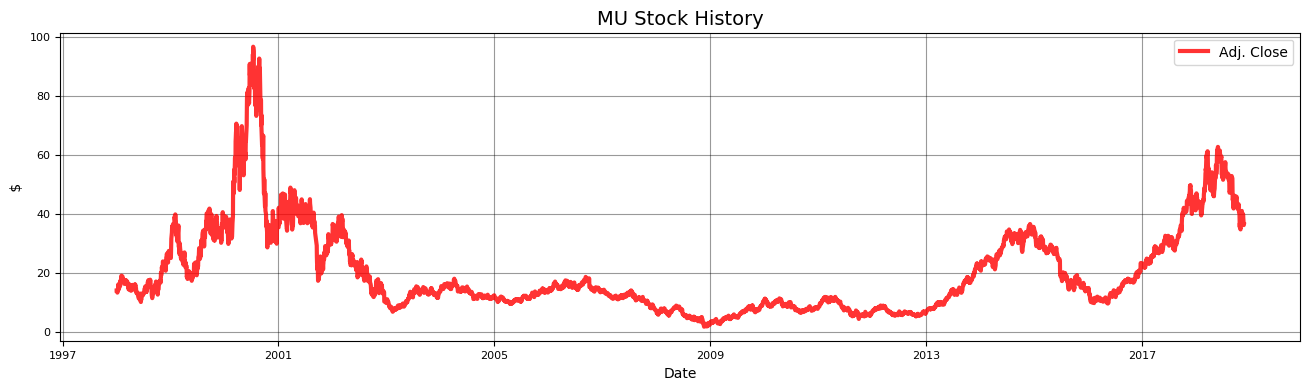

In [7]:
# plot historical data
myshare.plot_stock(start_date, end_date) #, stats=['Adj. Close'], plot_type='basic')

MU purchase price per share 60.75 and sold price 36.38, percentage changes = -40.12%
MU Total buy and hold profit from 2000-05-08 to 2018-11-21 for 100 shares = $-2437.00
2018-10-21


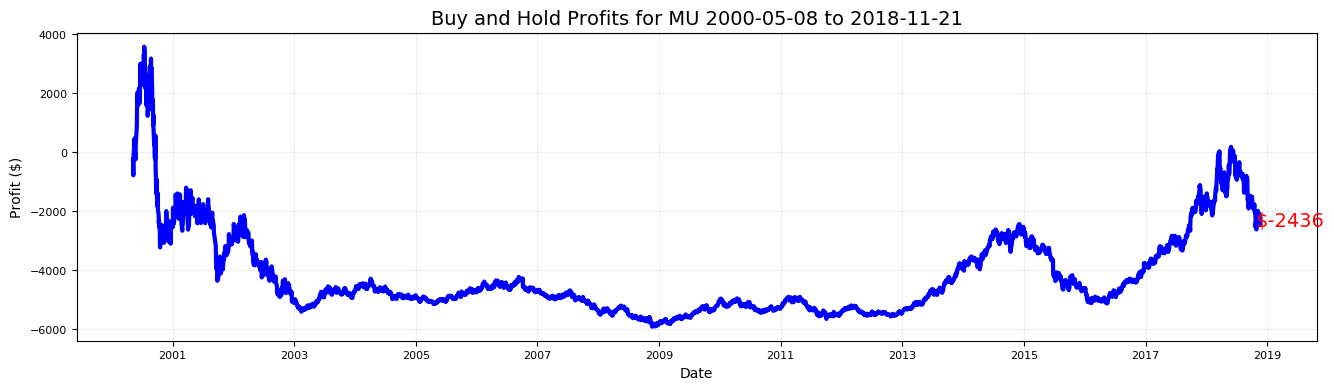

Oh no, I lose money


In [8]:
# quick check historical data based on if you buy on a certain date and sold at a certain date
yday = (datetime.now() - timedelta(2)).strftime('%Y-%m-%d')
yday
#make_money = myshare.buy_and_hold(start_date, end_date, nshares=1)


make_money = myshare.buy_and_hold(start_date='2000-05-06', end_date=yday, nshares=100)
if make_money:
    print ("Yeah, I make money")
else:
    print ("Oh no, I lose money")

<Figure size 1600x500 with 0 Axes>

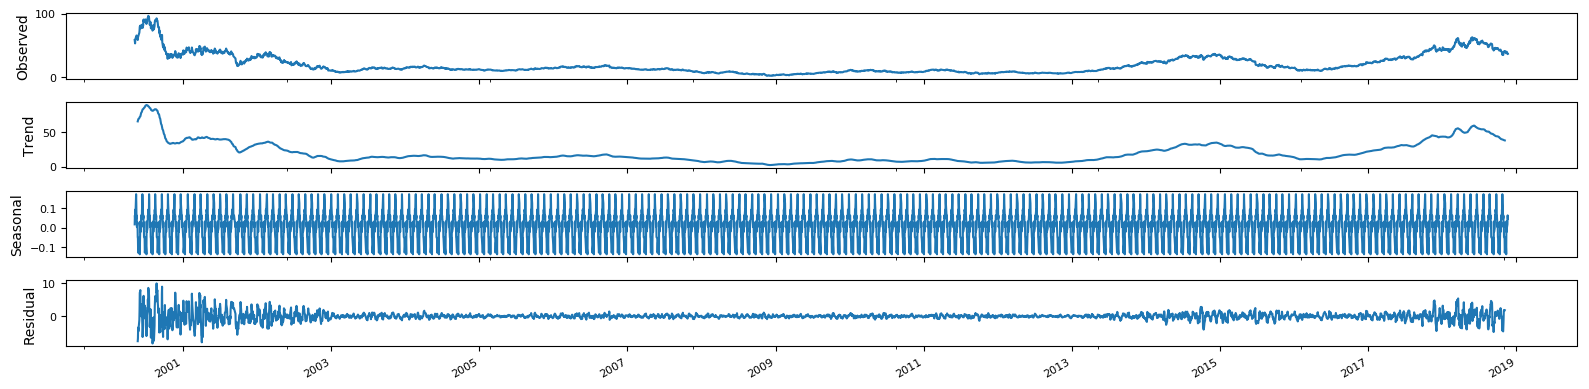

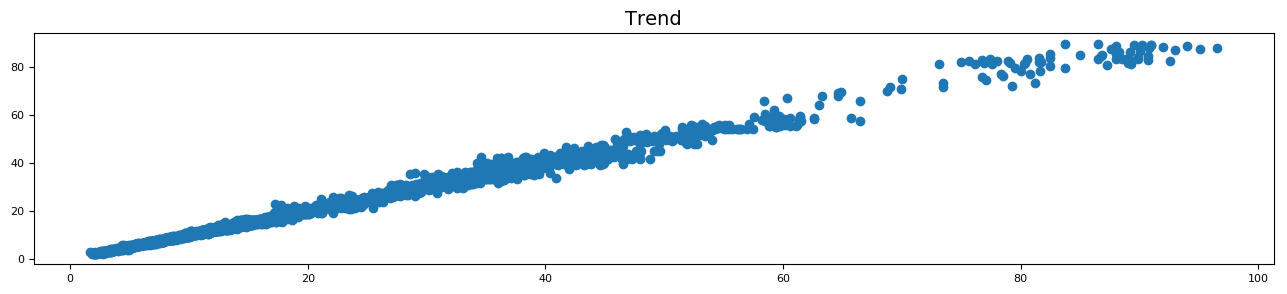

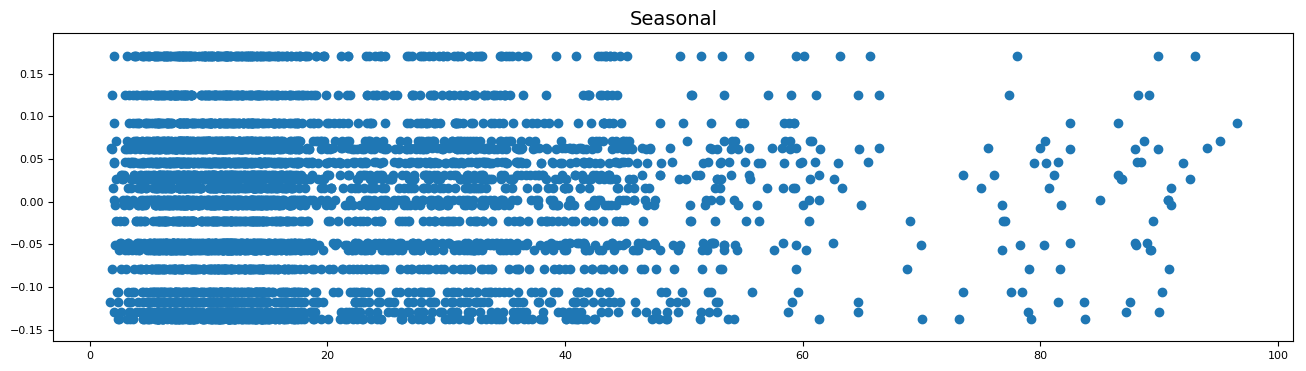

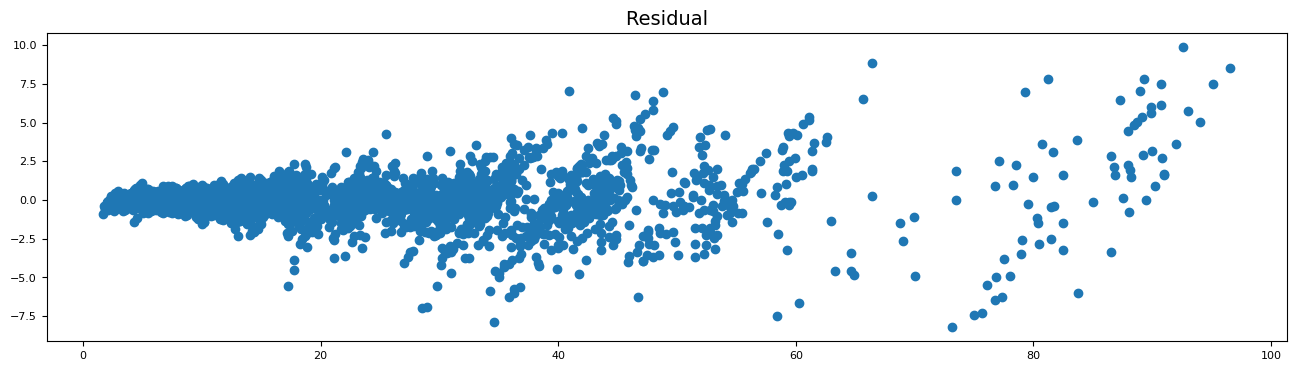

In [9]:
# see the components of time series


# # time series components 
# * trend - long term trend for inference
# * seasonal - seasonality i.e. holiday / winter for hot drinks, summer more ice-cream for sales
# * cyclic
# * random - irregular, errors, noises

myshare.decompose_timeseries(stats='Adj. Close', freq=22, model='additive')

In [10]:
start_date = myshare.get_start_date()
end_date = myshare.get_end_date()
df = myshare.get_trim_df_set()
print (start_date, end_date)
df.tail()

2000-05-08 00:00:00 2018-11-21 00:00:00


,Adj. Open,High,Low,Close,Adj. Close,Volume,Dividend,Coef,Date,ds,y,hold_profit
2000-05-12,58.88,62.88,58.88,60.75,60.75,6645700,0.0,1.0,2000-05-12,2000-05-12,60.75,0.0
2000-05-11,54.50,60.00,52.63,58.44,58.44,5408200,0.0,1.0,2000-05-11,2000-05-11,58.44,-231.0
2000-05-10,54.88,55.88,51.06,53.00,53.00,5539600,0.0,1.0,2000-05-10,2000-05-10,53.00,-775.0
2000-05-09,58.63,60.50,53.75,55.44,55.44,5577300,0.0,1.0,2000-05-09,2000-05-09,55.44,-531.0
2000-05-08,60.75,61.81,58.31,58.38,58.38,3208100,0.0,1.0,2000-05-08,2000-05-08,58.38,-237.0


In [11]:
# timeseries = df['Adj. Close'] - df['Adj. Close'].shift(1)
# print (timeseries.isnull().sum())
# timeseries.dropna(inplace=True)
# from statsmodels.tsa.stattools import adfuller
# dftest = adfuller(timeseries, autolag='AIC')

In [12]:
# # # time series components 
# # * trend - long term trend for inference
# # * seasonal - seasonality i.e. holiday / winter for hot drinks, summer more ice-cream for sales
# # * cyclic
# # * random - irregular, errors, noises

# # test stationary
# shift_no = 0

# for shift_num in range(0, 100):
#     print (shift_num)
#     is_stationary = nvda.test_stationarity(shift_num, stats='Adj. Close', wd=22)
#     print ('This share is stationary ' + str(is_stationary))
#     if is_stationary:
#         print ('already stationary - do nothing')
#         shift_no = shift_num
#         break
#     else:
#         print ('continue') # detrend it
# print (shift_no)

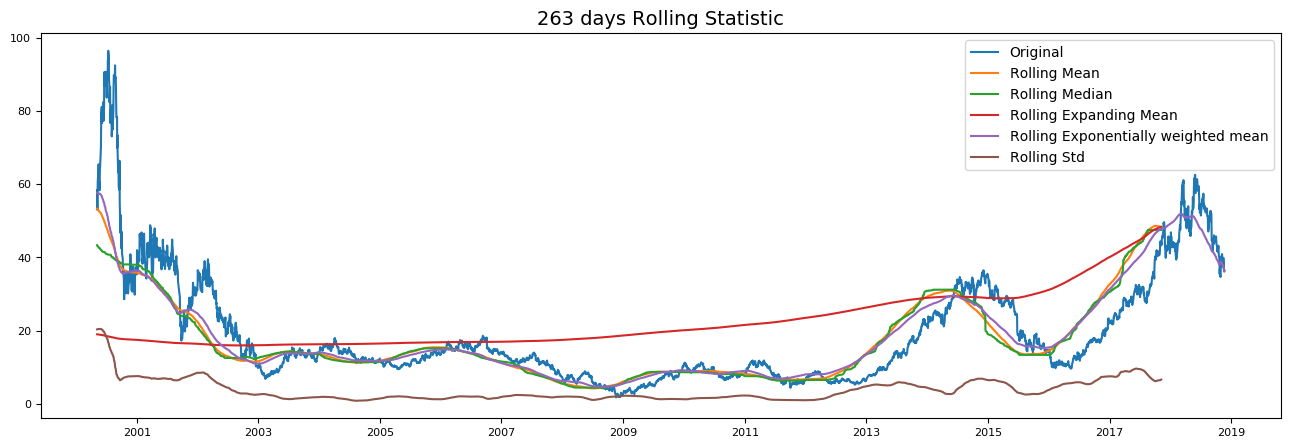

Results of Dickey-Fuller Test:
Test Statistic                   -2.287990
p-value                           0.175871
#Lags Used                       32.000000
Number of Observations Used    4634.000000
Critical Value (1%)              -3.431762
Critical Value (5%)              -2.862164
Critical Value (10%)             -2.567102
dtype: float64


In [13]:
is_stationary = myshare.test_stationarity(0, stats='Adj. Close', wd=263)

In [14]:
# # if is_stationary is true - do nothing
# # but if is_stationary is false - detrend it
# if is_stationary:
#     print ('already stationary - do nothing')
# else:
#     print ('need to do something') # detrend it
    

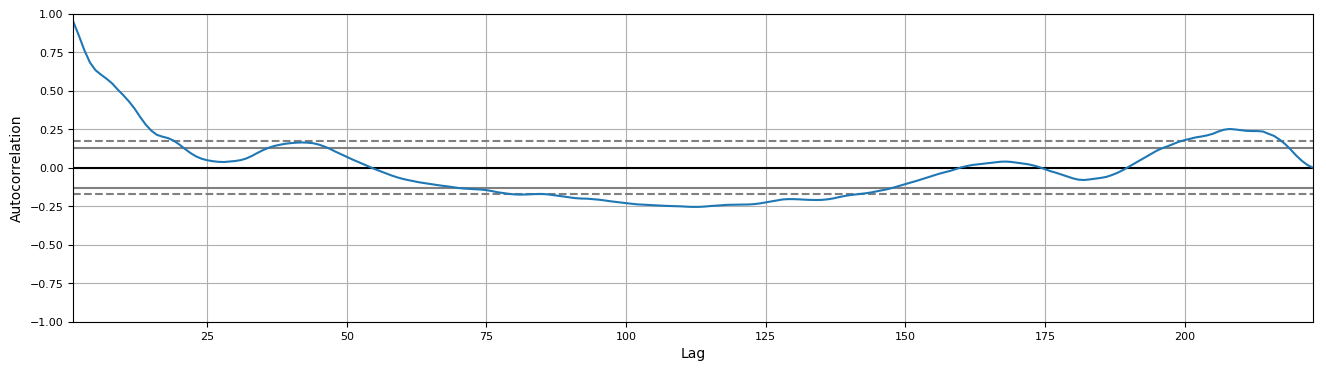

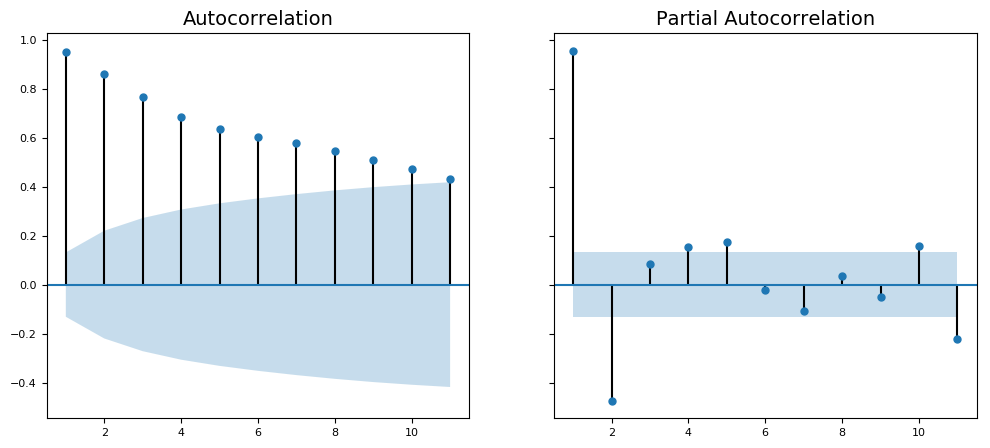

C:\Users\tzechiang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tzechiang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tzechiang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tzechiang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tzechiang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:889.5258760447898
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3834      0.089      4.297      0.000       0.209       0.558
ma.L1          0.1027      0.104      0.985      0.325      -0.102       0.307
ar.S.L12       0.3452      0.258      1.337      0.181      -0.161       0.852
ma.S.L12       0.1192      0.315      0.379      0.705      -0.497       0.736
sigma2         9.4767      0.458     20.677      0.000       8.578      10.375


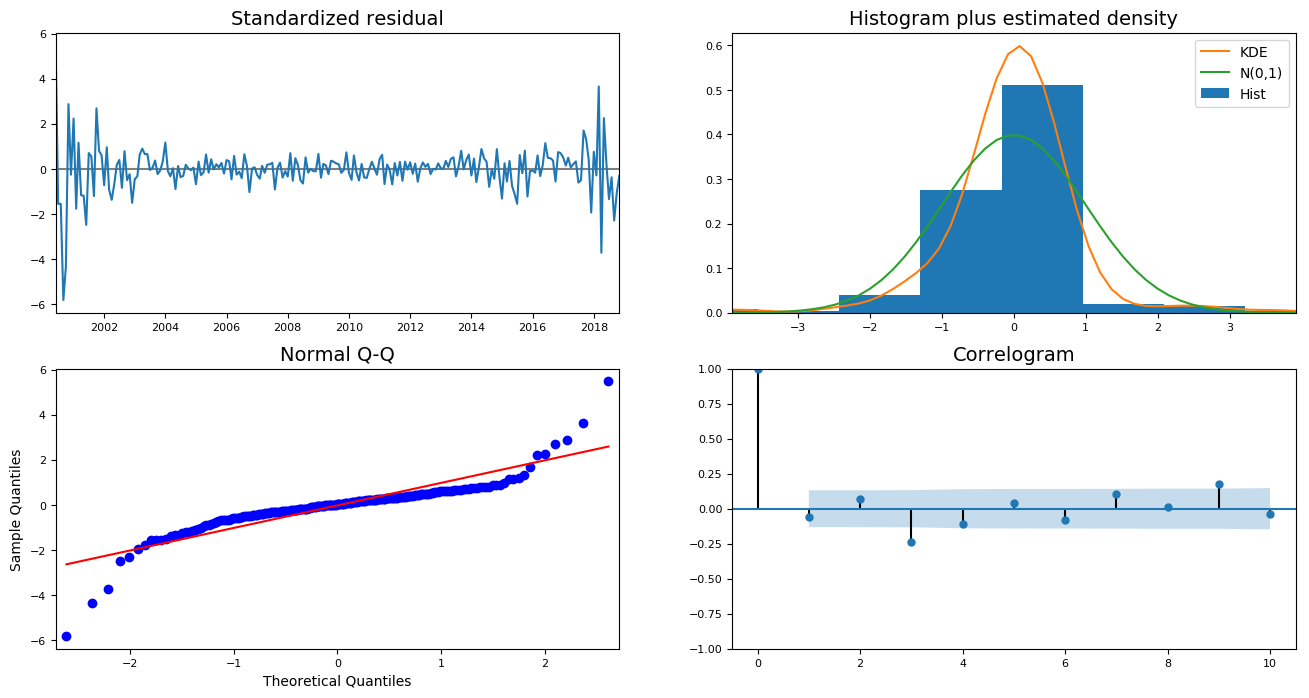

starting: 2000, ending: 2018, no of year for training: 2014
2015-1-1
prediction confident interval

            lower Adj. Close  upper Adj. Close
2015-01-01         29.140118         41.207352
2015-02-01         23.796181         35.863416


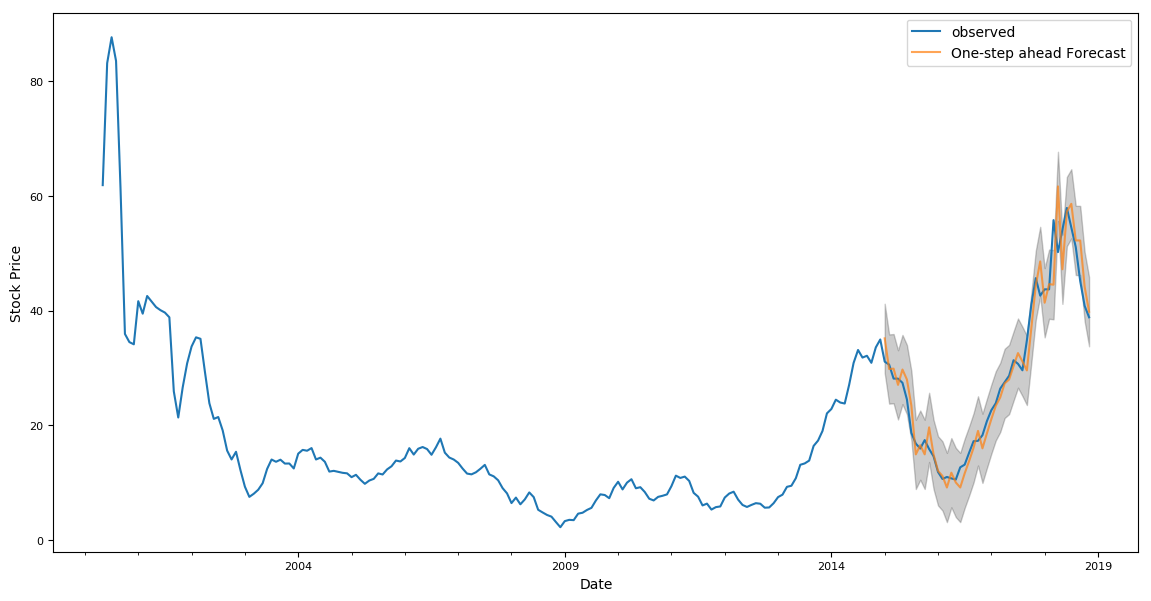

The Mean Squared Error of our forecasts is 12.94
The Root Mean Squared Error of our forecasts is 3.6
prediction confident interval

            lower Adj. Close  upper Adj. Close
2018-12-01         29.577978         41.645212
2019-01-01         24.554854         46.169499


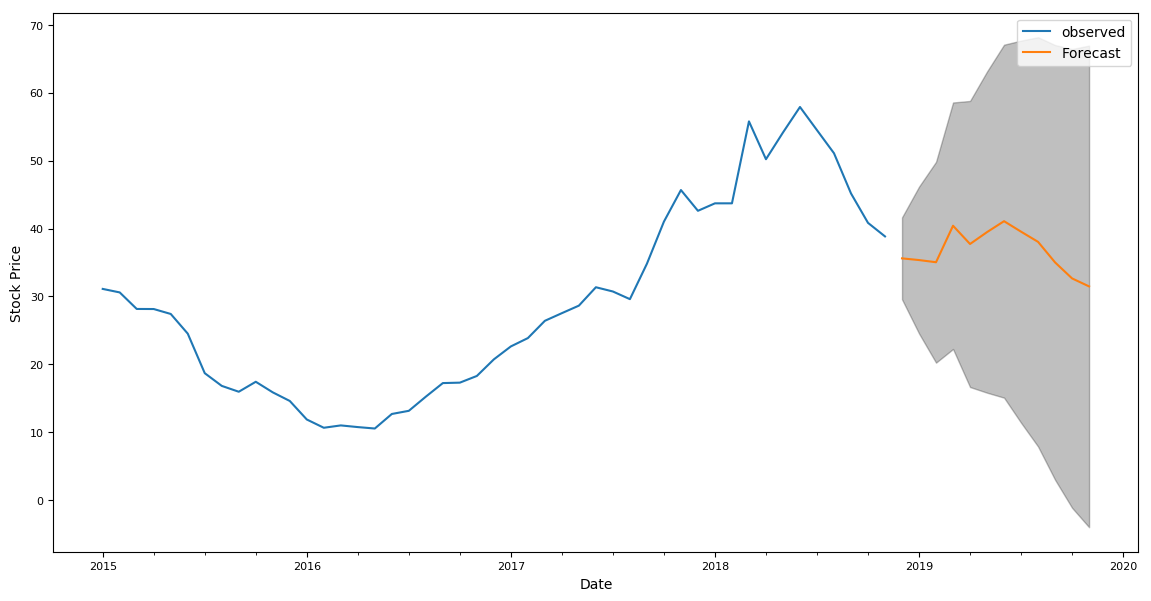

In [15]:
# applied the SARIMA model
y_forecasted, pred, pred_uc = myshare.sarima_model(shift_no=0, stats='Adj. Close', freq='MS')

In [16]:
# # found by googling that cumsum() can be used to convert back to actual values
# pred = fitted_values_arma.predict(start=start, end=end)
# predictions_ARIMA_diff = pd.Series(pred, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# plt.plot(predictions_ARIMA_diff_cumsum)
# plt.plot(predictions_ARIMA_diff)
# pred

In [17]:
pred_uc.conf_int().head(10)

,lower Adj. Close,upper Adj. Close
2018-12-01,29.577978,41.645212
2019-01-01,24.554854,46.169499
2019-02-01,20.256654,49.828162
2019-03-01,22.267804,58.562386
2019-04-01,16.667325,58.787863
2019-05-01,15.833591,63.124351
2019-06-01,15.100852,67.069919
2019-07-01,11.408019,67.674839
2019-08-01,7.909386,68.170769
2019-09-01,3.012529,67.020588


In [19]:
prediction = pred_uc.conf_int()
prediction['AVG'] = (prediction['lower Adj. Close'] + prediction['upper Adj. Close']) / 2
prediction

,lower Adj. Close,upper Adj. Close,AVG
2018-12-01,29.577978,41.645212,35.611595
2019-01-01,24.554854,46.169499,35.362177
2019-02-01,20.256654,49.828162,35.042408
2019-03-01,22.267804,58.562386,40.415095
2019-04-01,16.667325,58.787863,37.727594
2019-05-01,15.833591,63.124351,39.478971
2019-06-01,15.100852,67.069919,41.085386
2019-07-01,11.408019,67.674839,39.541429
2019-08-01,7.909386,68.170769,38.040077
2019-09-01,3.012529,67.020588,35.016559
